In [1]:
import numpy as np
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split

# Exploratory data analysis
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(color_codes=True)
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.figure_factory as ff

from sklearn.metrics import classification_report, confusion_matrix,ConfusionMatrixDisplay
from sklearn import preprocessing

from IPython.display import display

from pathlib import Path

In [2]:
class LinearSVM:
    def __init__(self, learning_rate=0.001, epochs=10000, C=1.0):
        self.learning_rate = learning_rate
        self.epochs = epochs
        self.C = C
        self.weights = None
        self.bias = None

    def train(self, X, y):
        num_samples, num_features = X.shape
        self.weights = np.zeros(num_features)
        self.bias = 0
        min = float('inf')
        max = float('inf')
        for epoch in range(self.epochs):
            # print(self.weights)
            for i in range(num_samples):
                pred = np.dot(X[i], self.weights) - self.bias
                condition = y[i] * pred > 0
                if not condition:
                    self.weights -= self.learning_rate * (2 * self.C * self.weights - np.dot(X[i], y[i]))
                    self.bias -= self.learning_rate * y[i]

    def predict(self, X):
        return np.sign(np.dot(X, self.weights) - self.bias)

In [2]:
# Import training data
data_folder = Path("data-sets")
train_data = pd.read_csv("data-sets/train.csv")
test_data = pd.read_csv("data-sets/test.csv") # test data is useless, has no credit score column

#columns to drop
drop = ['ID', 'Customer_ID', 'Month', 'Name', 'SSN', 'Occupation', 'Type_of_Loan', 'Credit_Mix', 'Credit_History_Age', 'Payment_of_Min_Amount', 'Payment_Behaviour']

#columns to clean
clean = ['Age', 'Annual_Income', 'Monthly_Inhand_Salary', 'Num_Bank_Accounts', 'Num_Credit_Card', 'Interest_Rate', 'Num_of_Loan', 'Delay_from_due_date', 'Num_of_Delayed_Payment', 'Changed_Credit_Limit', 'Num_Credit_Inquiries', 'Outstanding_Debt', 'Credit_Utilization_Ratio', 'Credit_History_Age', 'Total_EMI_per_month', 'Amount_invested_monthly', 'Monthly_Balance']

#clean columns
for item in clean:
    train_data[item] = (train_data[item].astype(str)).str.extract(r'^((?:\d*\.\d+|\d+)$)', expand=False).astype(float)

#map credit scores to number
creditScoreMap = {'Poor': 1, 'Standard': 2, 'Good': 3}
train_data['Credit_Score'] = train_data['Credit_Score'].replace(creditScoreMap)

# #copy data and drop non-numeric columns
df = train_data.copy().drop(columns=drop)
df.dropna(inplace=True)
df = df.reset_index(drop=True)

In [3]:
X, y = df.drop(columns=['Credit_Score']), df['Credit_Score']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)

In [4]:
svc_li = SVC(kernel='linear')

scaler = preprocessing.StandardScaler()
scaler.fit(X_train)

Z_svm_train = scaler.transform(X_train)
Z_svm_test = scaler.transform(X_test)

svc_li.fit(Z_svm_train, np.asarray(y_train))

print('Linear Kernel')
print(classification_report(y_test, svc_li.predict(Z_svm_test)))
print("Confusion Matrix:\n", confusion_matrix(y_test, svc_li.predict(Z_svm_test)))


Linear Kernel
              precision    recall  f1-score   support

           1       0.62      0.41      0.50      2774
           2       0.58      0.87      0.70      5064
           3       0.00      0.00      0.00      1565

    accuracy                           0.59      9403
   macro avg       0.40      0.43      0.40      9403
weighted avg       0.50      0.59      0.52      9403

Confusion Matrix:
 [[1145 1629    0]
 [ 667 4397    0]
 [  32 1533    0]]


In [7]:
# w/ rbf kernel
svc_rbf = SVC(kernel='rbf')

scaler = preprocessing.StandardScaler()
scaler.fit(X_train)

Z_svm_train = scaler.transform(X_train)
Z_svm_test = scaler.transform(X_test)

svc_rbf.fit(Z_svm_train, np.asarray(y_train))

print('RBF Kernel')
print(classification_report(y_test, svc_rbf.predict(Z_svm_test)))
print("Confusion Matrix:\n", confusion_matrix(y_test, svc_rbf.predict(Z_svm_test)))

RBF Kernel
              precision    recall  f1-score   support

           1       0.70      0.48      0.57      2774
           2       0.60      0.88      0.72      5064
           3       0.56      0.02      0.05      1565

    accuracy                           0.62      9403
   macro avg       0.62      0.46      0.44      9403
weighted avg       0.62      0.62      0.56      9403

Confusion Matrix:
 [[1340 1430    4]
 [ 570 4468   26]
 [  16 1511   38]]


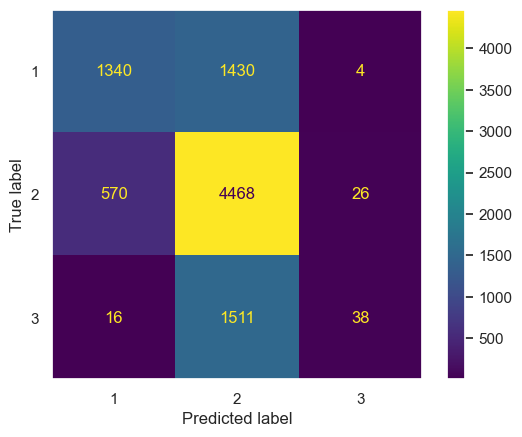

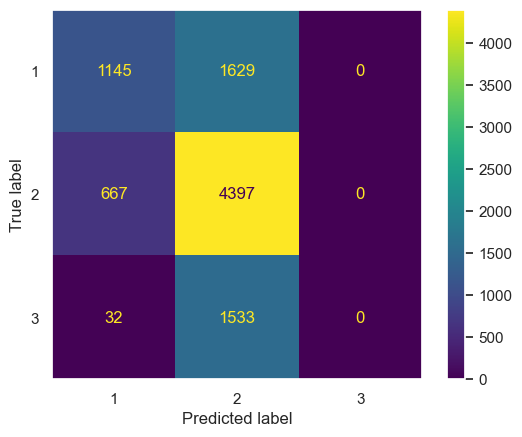

In [12]:
cm_svm_rbf = confusion_matrix(y_test, svc_rbf.predict(Z_svm_test))
cm_svm_li = confusion_matrix(y_test, svc_li.predict(Z_svm_test))
cm_display_rbf = ConfusionMatrixDisplay(cm_svm_rbf,display_labels=svc_rbf.classes_).plot()
plt.grid(False)
cm_display_li = ConfusionMatrixDisplay(cm_svm_li,display_labels=svc_li.classes_).plot()
plt.grid(False)
plt.show()

In [7]:
from imblearn.over_sampling import RandomOverSampler # might need to downgrade sklearn to previous version
ros = RandomOverSampler()
X_os, y_os = ros.fit_resample(X_train, y_train)

scaler = preprocessing.StandardScaler()
Z_trainos = scaler.fit_transform(X_os)
Z_svm_test = scaler.transform(X_test)

print(y_os.value_counts())

# linear kernel
svc_li = SVC(kernel='linear')
svc_li.fit(Z_trainos, np.asarray(y_os))

print('Linear Kernel')
print(classification_report(y_test, svc_li.predict(Z_svm_test)))

# RBF kernel
svc_rbf = SVC(kernel='rbf')
svc_rbf.fit(Z_trainos, np.asarray(y_os))

print('RBF Kernel')
print(classification_report(y_test, svc_rbf.predict(Z_svm_test)))

Credit_Score
2    20272
1    20272
3    20272
Name: count, dtype: int64
Linear Kernel
              precision    recall  f1-score   support

           1       0.60      0.65      0.62      2774
           2       0.72      0.40      0.52      5064
           3       0.35      0.80      0.49      1565

    accuracy                           0.54      9403
   macro avg       0.56      0.62      0.54      9403
weighted avg       0.62      0.54      0.54      9403

RBF Kernel
              precision    recall  f1-score   support

           1       0.60      0.73      0.66      2774
           2       0.77      0.41      0.53      5064
           3       0.36      0.79      0.50      1565

    accuracy                           0.56      9403
   macro avg       0.58      0.64      0.56      9403
weighted avg       0.65      0.56      0.56      9403



In [10]:
# someone test the undersampling for me; it took > 20 min to run the oversampling
# https://machinelearningmastery.com/undersampling-algorithms-for-imbalanced-classification/
from imblearn.under_sampling import RandomUnderSampler
rus = RandomUnderSampler()
X_us, y_us = rus.fit_resample(X_train, y_train)

scaler = preprocessing.StandardScaler()
Z_trainus = scaler.fit_transform(X_us)
Z_svm_test = scaler.transform(X_test)

print(y_us.value_counts())

# linear kernel
svc_li = SVC(kernel='linear')
svc_li.fit(Z_trainus, np.asarray(y_us))

print('Linear Kernel')
print(classification_report(y_test, svc_li.predict(Z_svm_test)))

# RBF kernel
svc_rbf = SVC(kernel='rbf')
svc_rbf.fit(Z_trainus, np.asarray(y_us))

print('RBF Kernel')
print(classification_report(y_test, svc_rbf.predict(Z_svm_test)))

Credit_Score
1    6370
2    6370
3    6370
Name: count, dtype: int64
Linear Kernel
              precision    recall  f1-score   support

           1       0.60      0.65      0.62      2774
           2       0.72      0.40      0.51      5064
           3       0.35      0.80      0.49      1565

    accuracy                           0.54      9403
   macro avg       0.56      0.62      0.54      9403
weighted avg       0.62      0.54      0.54      9403

RBF Kernel
              precision    recall  f1-score   support

           1       0.60      0.73      0.66      2774
           2       0.77      0.39      0.52      5064
           3       0.36      0.80      0.50      1565

    accuracy                           0.56      9403
   macro avg       0.57      0.64      0.56      9403
weighted avg       0.65      0.56      0.55      9403



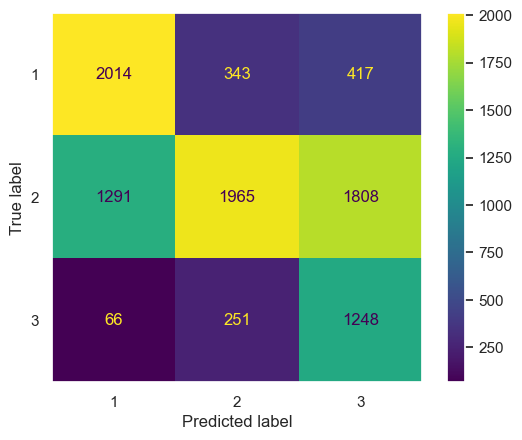

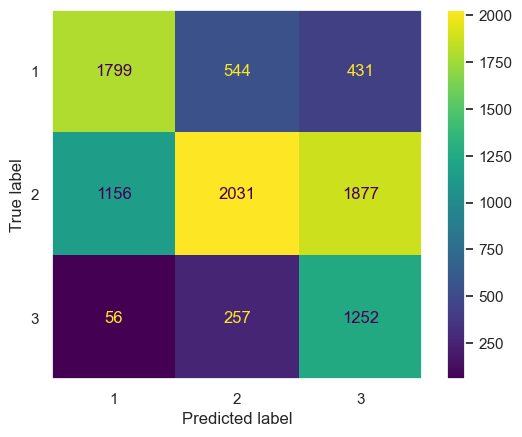

In [11]:
cm_svm_rbf = confusion_matrix(y_test, svc_rbf.predict(Z_svm_test))
cm_svm_li = confusion_matrix(y_test, svc_li.predict(Z_svm_test))
cm_display_rbf = ConfusionMatrixDisplay(cm_svm_rbf,display_labels=svc_rbf.classes_).plot()
plt.grid(False)
cm_display_li = ConfusionMatrixDisplay(cm_svm_li,display_labels=svc_li.classes_).plot()
plt.grid(False)
plt.show()